In [184]:
import re
import pandas as pd
import uncertainties as un
import uncertainties.unumpy as unp
import numpy as np
import matplotlib.pyplot as plt

idx = pd.IndexSlice

plt.rcParams['axes.labelsize'] = 'large'
nom = unp.nominal_values
err = unp.std_devs

# Load Data

In [185]:
# read data
nd = pd.read_csv('data/raw_Neptune_stripped.csv')
# parse datetime
nd.loc[:, 'datetime'] = pd.to_datetime(nd.loc[:, 'Date'] + ' ' + nd.loc[:, 'Time'], format='%d/%m/%y %H:%M:%S')

# calculate minute timescale for each run
nd.loc[:, 'run_minutes'] = 0
for k, g in nd.groupby('Run'):
    nd.loc[nd.Run == k, 'run_minutes'] = (g.datetime - g.datetime.min()).dt.total_seconds() / 60

In [186]:
iblank = nd.Sample == 'Blank'
iwash = nd.Sample == 'Wash'
iLSVEC = nd.Sample.str.contains('SVEC')
iext = nd.Sample.str.contains('ext')
isample = ~(iblank ^ iwash ^ iLSVEC ^ iext)

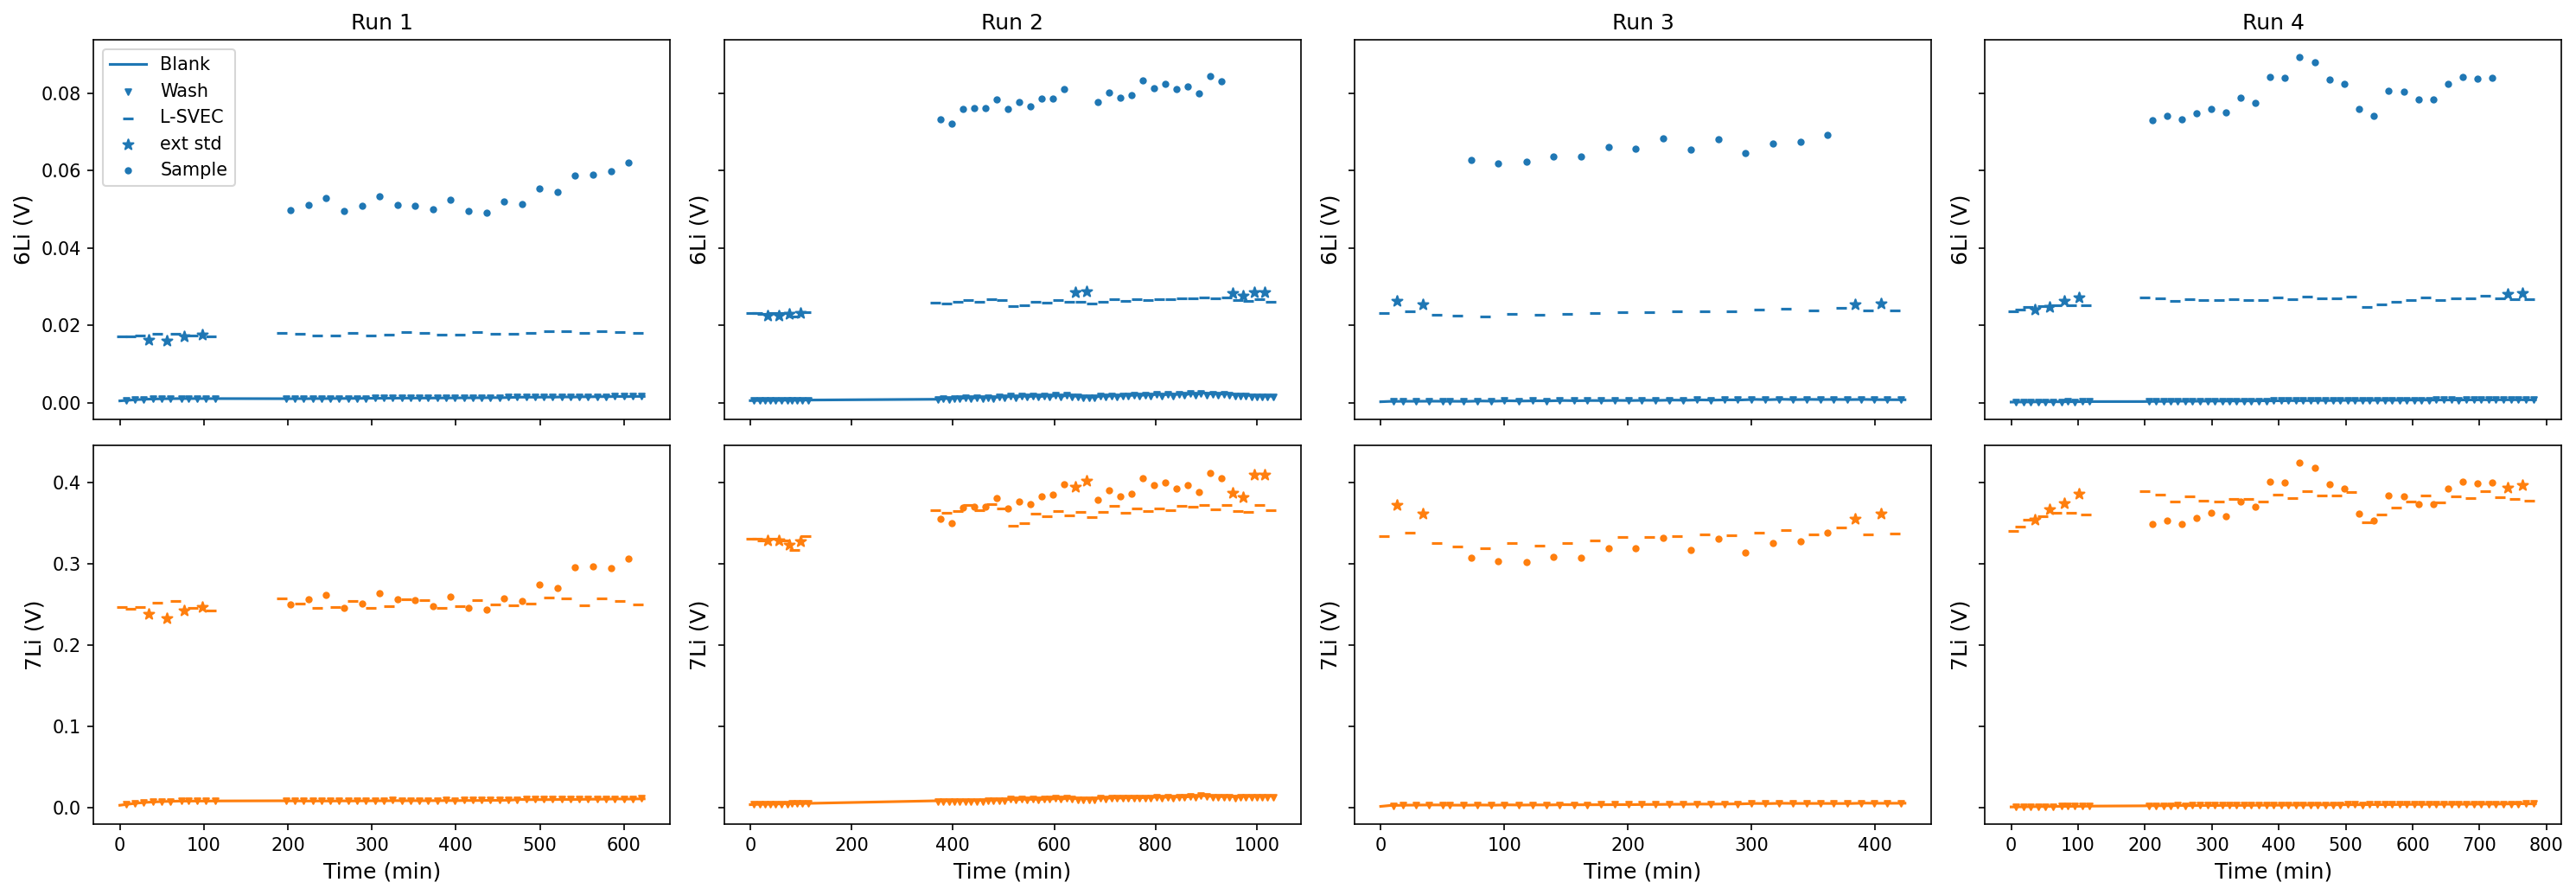

In [187]:
c6Li = 'C0'
c7Li = 'C1'
crLi = 'C2'
xvar = 'run_minutes'

nruns = int(nd.Run.max())

r_plot = [1,2,3,4]
nruns = len(r_plot)

fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    if r not in r_plot:
        continue
    
    snd = nd.loc[nd.Run == r]
    ax6, ax7 = axs[:, r-1]

    ax6.plot(snd.loc[iblank, xvar], snd.loc[iblank, '6Li'], c=c6Li, label='Blank')
    ax7.plot(snd.loc[iblank, xvar], snd.loc[iblank, '7Li'], c=c7Li)

    ax6.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '6Li'], c=c6Li, s=10, marker='v', label='Wash')
    ax7.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '7Li'], c=c7Li, s=10, marker='v')

    ax6.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '6Li'], c=c6Li, marker='_', label='L-SVEC')
    ax7.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li'], c=c7Li, marker='_')

    ax6.scatter(snd.loc[iext, xvar], snd.loc[iext, '6Li'], c=c6Li, marker='*', label='ext std')
    ax7.scatter(snd.loc[iext, xvar], snd.loc[iext, '7Li'], c=c7Li, marker='*')
    
    ax6.scatter(snd.loc[isample, xvar], snd.loc[isample, '6Li'], c=c6Li, marker='.', label='Sample')
    ax7.scatter(snd.loc[isample, xvar], snd.loc[isample, '7Li'], c=c7Li, marker='.')

    ax6.set_ylabel('6Li (V)')
    ax7.set_ylabel('7Li (V)')
    
    ax6.set_title('Run {}'.format(r))
    ax7.set_xlabel('Time (min)')

axs[0, 0].legend()
    
fig.tight_layout()

## Data Processing

In [188]:
nd.loc[:, 'c6Li'] = pd.Series(dtype='object')
nd.loc[:, 'c7Li'] = pd.Series(dtype='object')

nd.loc[:, 'c7Li/c6Li'] = pd.Series(dtype='object')
nd.loc[:, 'alpha_Sample-LSVEC'] = pd.Series(dtype='object')

# process each run separately
for r, g in nd.groupby('Run'):
    # isolate blank, wash, LSVEC, and sample indices
    siblank = g.Sample == 'Blank'
    siwash = g.Sample == 'Wash'
    siLSVEC = g.Sample.str.contains('SVEC')
    sisample = ~(siblank ^ siwash ^ siLSVEC)

    # blank correct LSVEC
    LSVEC_indices = g.loc[siLSVEC].index
    
    # identify bracketing blanks and subtract their mean
    for i in LSVEC_indices:
        pre_offset = 1
        while g.loc[i - pre_offset, 'Sample'] != 'Blank':
            pre_offset += 1
                
        post_offset = 1
        while g.loc[i + post_offset, 'Sample'] != 'Blank':
            post_offset += 1
        
        blank_indices = [i - pre_offset, i + post_offset]

        nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - nd.loc[blank_indices, '6Li'].mean()
        nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - nd.loc[blank_indices, '7Li'].mean()

        # calculate blank corrected ratio
        nd.loc[i, 'c7Li/c6Li'] = nd.loc[i, 'c7Li'] / nd.loc[i, 'c6Li']

    # blank correct samples and calculate alpha
    sample_indices = g.loc[sisample].index

    for i in sample_indices:
        # identify bracketing blanks and subtract their mean
        pre_offset = 1
        while g.loc[i - pre_offset, 'Sample'] != 'Blank':
            pre_offset += 1
                
        post_offset = 1
        while g.loc[i + post_offset, 'Sample'] != 'Blank':
            post_offset += 1
        
        blank_indices = [i - pre_offset, i + post_offset]
        
        nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - nd.loc[blank_indices, '6Li'].mean()
        nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - nd.loc[blank_indices, '7Li'].mean()

        # calculate blank corrected ratio
        nd.loc[i, 'c7Li/c6Li'] = nd.loc[i, 'c7Li'] / nd.loc[i, 'c6Li']
        
        # calculate alpha: divide by bracketing LSVEC ratios
        bracketing_LSVECs = LSVEC_indices[np.argsort(abs(LSVEC_indices - i))[:2]]
        
        # if bracketing LSVECs are more than 0.1% different, only use the one before the sample
        v = unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].values)
        if v.std() / v.mean() > 0.001:
            bracketing_LSVECs = [bracketing_LSVECs[0]]
            v = unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'])
        
        # calculate alpha
        nd.loc[i, 'alpha_Sample-LSVEC'] = nd.loc[i, 'c7Li/c6Li'] / nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].values.mean()

# calculate delta values
nd.loc[:, 'delta_Sample-LSVEC'] = (nd.loc[:, 'alpha_Sample-LSVEC'] - 1) * 1000

### External Standard Check

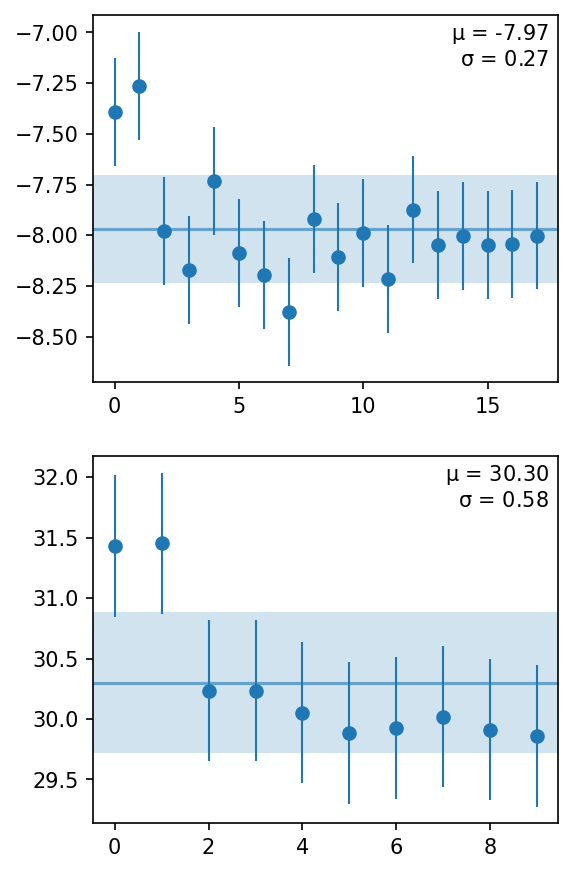

In [189]:
ext = nd.loc[iext]

fig, axs = plt.subplots(2, 1, figsize=[4, 7])

for ax, exstd in zip(axs, ['6Li ext std', '7Li ext std']):
    ind = ext.Sample == exstd
    x = np.arange(sum(ind))
    ax.errorbar(x, nom(ext.loc[ind, 'delta_Sample-LSVEC']), std(ext.loc[ind, 'delta_Sample-LSVEC']), lw=0, elinewidth=1, marker='o')
    
    mu = np.mean(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    sigma = np.std(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    ax.axhline(mu, alpha=0.6)
    ax.axhspan(mu - sigma, mu + sigma, alpha=0.2)
    
    ax.text(.98, .98, f'$\\mu$ = {mu:.2f}\n$\\sigma$ = {sigma:.2f}', transform=ax.transAxes, va='top', ha='right')

## Format Data for Export

In [190]:
def mean(d):
    return np.mean(d.values)

def std(d):
    return np.std(d.values)

sam = nd.loc[isample, ['Sample','alpha_Sample-LSVEC','delta_Sample-LSVEC']].groupby('Sample').aggregate([mean, std, len])

In [191]:
sam_alpha = nd.loc[isample, ['Sample','alpha_Sample-LSVEC', 'Run']].groupby('Sample').aggregate([mean, std, len])

sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid')] = sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'mean')]
sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid_std')] = sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'std')]
sam_alpha.drop('alpha_Sample-LSVEC', axis=1, inplace=True)

### Isolate Fluids

In [192]:
iliq = sam.index.str.contains('pre') | sam.index.str.contains('post')
isol = ~iliq

experiments = sam.loc[isol].index
solids = sam.loc[isol]
rsolns = sam.loc[iliq]

# parse out pre/post experiment solution measurements
solns = pd.DataFrame(columns=pd.MultiIndex.from_product([sam.columns.levels[0], ['pre', 'post']]))

cols = ['alpha_Sample-LSVEC', 'delta_Sample-LSVEC']

parse_name = re.compile('(C?[0-9].[0-9]) ?([preost]+)')
for k, r in rsolns.iterrows():
    cond, prepost = parse_name.match(k).groups()
    vals = unp.uarray(r.loc[idx[:, 'mean']].values, r.loc[idx[:, 'std']].values)

    solns.loc[cond, (cols, prepost)] = vals

In [193]:
for p in ['pre', 'post']:
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p)] = unp.nominal_values(solns.loc[:, ('alpha_Sample-LSVEC', p)])
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p + '_std')] = unp.std_devs(solns.loc[:, ('alpha_Sample-LSVEC', p)])

In [194]:
solns

alpha_Sample-LSVEC                      delta_Sample-LSVEC  \
                      pre                 post                pre   
1.1   0.330427+/-0.000029  0.330464+/-0.000030   -669.573+/-0.029   
2.1     0.33051+/-0.00008    0.33051+/-0.00008     -669.49+/-0.08   
3.1   0.330536+/-0.000019    0.33049+/-0.00005   -669.464+/-0.019   
4.1   0.330495+/-0.000019  0.330518+/-0.000004   -669.505+/-0.019   
5.1     0.33065+/-0.00005    0.33011+/-0.00011     -669.35+/-0.05   
6.1     0.33017+/-0.00006    0.33033+/-0.00014     -669.83+/-0.06   
7.1     0.33126+/-0.00011    0.33176+/-0.00019     -668.74+/-0.11   
8.1       0.3323+/-0.0006    0.33110+/-0.00007       -667.7+/-0.6   
8.2       0.3308+/-0.0004    0.33247+/-0.00028       -669.2+/-0.4   
C1.1    0.33035+/-0.00013  0.330410+/-0.000034     -669.65+/-0.13   
C2.1    0.33157+/-0.00008  0.331546+/-0.000013     -668.43+/-0.08   
C2.3      0.3318+/-0.0005  0.331650+/-0.000015       -668.2+/-0.5   

                       Li_isotopes_alpha_LSVEC                           \
                  post               fluid_pre fluid_pre_std fluid_post   
1.1   -669.536+/-0.030                0.330427      0.000029   0.330464   
2.1     -669.49+/-0.08                0.330510      0.000079   0.330512   
3.1     -669.51+/-0.05                0.330536      0.000019   0.330493   
4.1   -669.482+/-0.004                0.330495      0.000019   0.330518   
5.1     -669.89+/-0.11                0.330654      0.000051   0.330110   
6.1     -669.67+/-0.14                0.330170      0.000063   0.330331   
7.1     -668.24+/-0.19                0.331258      0.000111   0.331760   
8.1     -668.90+/-0.07                0.332317      0.000599   0.331101   
8.2     -667.53+/-0.28                0.330783      0.000362   0.332471   
C1.1  -669.590+/-0.034                0.330351      0.000132   0.330410   
C2.1  -668.454+/-0.013                0.331569      0.000077   0.331546   
C2.3  -668.350+/-0.015                0.331843      0.000499   0.331650   

                     
     fluid_post_std  
1.1        0.000030  
2.1        0.000084  
3.1        0.000052  
4.1        0.000004  
5.1        0.000114  
6.1        0.000142  
7.1        0.000186  
8.1        0.000065  
8.2        0.000279  
C1.1       0.000034  
C2.1       0.000013  
C2.3       0.000015

In [195]:
solns.loc[:, idx['Li_isotopes_alpha_LSVEC', :]]

Li_isotopes_alpha_LSVEC                                        
                   fluid_pre fluid_pre_std fluid_post fluid_post_std
1.1                 0.330427      0.000029   0.330464       0.000030
2.1                 0.330510      0.000079   0.330512       0.000084
3.1                 0.330536      0.000019   0.330493       0.000052
4.1                 0.330495      0.000019   0.330518       0.000004
5.1                 0.330654      0.000051   0.330110       0.000114
6.1                 0.330170      0.000063   0.330331       0.000142
7.1                 0.331258      0.000111   0.331760       0.000186
8.1                 0.332317      0.000599   0.331101       0.000065
8.2                 0.330783      0.000362   0.332471       0.000279
C1.1                0.330351      0.000132   0.330410       0.000034
C2.1                0.331569      0.000077   0.331546       0.000013
C2.3                0.331843      0.000499   0.331650       0.000015

In [196]:
sam_alpha = sam_alpha.join(solns.loc[:, idx['Li_isotopes_alpha_LSVEC', :]])

In [197]:
sam_alpha = sam_alpha.loc[~(sam_alpha.index.str.contains('post') | sam_alpha.index.str.contains('pre'))]

sam_alpha.to_csv('data/processed_Neptune.csv')

In [198]:
sam_alpha['sample'] = [s[0] for s in sam_alpha.index.str.split('.')]

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, 'C1'),
 Text(9, 0, 'C2')]

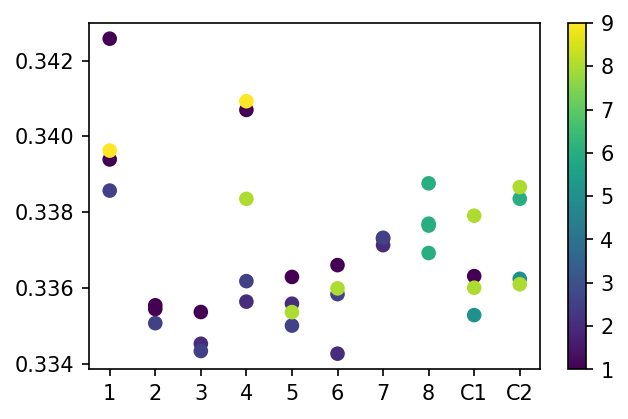

In [199]:
fig, ax = plt.subplots(1,1)

for i, s in enumerate(sam_alpha['sample'].unique()):
    sub = sam_alpha.loc[sam_alpha['sample'] == s]
    ma = ax.scatter([i] * sub.shape[0], sub[('Li_isotopes_alpha_LSVEC', 'solid')], c=sub[('Run', 'mean')], label=s, vmin=1, vmax=9)

fig.colorbar(ma)
ax.set_xticks(range(len(sam_alpha['sample'].unique())))
ax.set_xticklabels(sam_alpha['sample'].unique())

## Standardise to solution

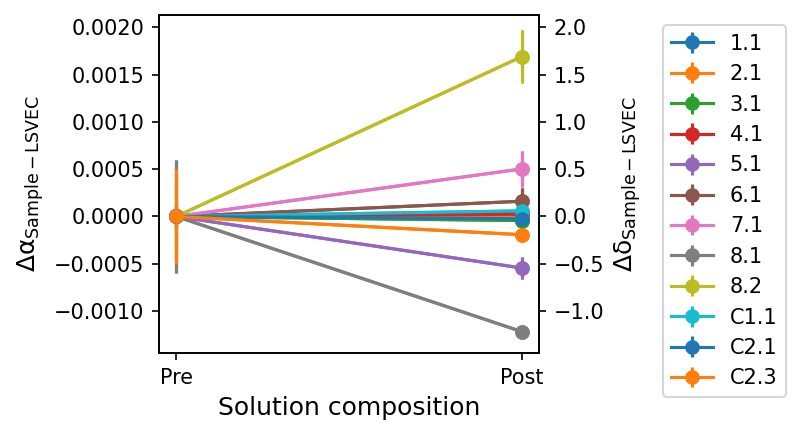

In [200]:
# compare pre/post solutions

fig, aax = plt.subplots(1, 1)

dax = aax.twinx()

for k, r in solns.iterrows():
    alpha = r.loc['alpha_Sample-LSVEC']
    delta = r.loc['delta_Sample-LSVEC']
    aax.errorbar([0, 1], nom(alpha - alpha.pre), err(alpha), marker='o', label=k)
    dax.errorbar([0, 1], nom(delta - delta.pre), err(delta), marker='o', label=k)

aax.legend(bbox_to_anchor=(1.3, 1))

aax.set_ylabel('$\\Delta \\alpha_{Sample-LSVEC}$')
dax.set_ylabel('$\\Delta \\delta_{Sample-LSVEC}$')

aax.set_xticks([0, 1])
aax.set_xticklabels(['Pre', 'Post'])
aax.set_xlabel('Solution composition')

fig.tight_layout()

In [201]:
# split index into useful multiindex
solids.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solids.index.str.split('.')], names=['condition', 'replicate'])
solns.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solns.index.str.split('.')], names=['condition', 'replicate'])

In [202]:
# calculate means
solns.loc[:, ('alpha_Sample-LSVEC', 'mean')] = solns.loc[:, 'alpha_Sample-LSVEC'].values.mean(1)
solns.loc[:, ('delta_Sample-LSVEC', 'mean')] = solns.loc[:, 'delta_Sample-LSVEC'].values.mean(1)
solns.sort_index(level=1, inplace=True)

In [203]:
solns

alpha_Sample-LSVEC                       \
                                     pre                 post   
condition replicate                                             
1         1          0.330427+/-0.000029  0.330464+/-0.000030   
2         1            0.33051+/-0.00008    0.33051+/-0.00008   
3         1          0.330536+/-0.000019    0.33049+/-0.00005   
4         1          0.330495+/-0.000019  0.330518+/-0.000004   
5         1            0.33065+/-0.00005    0.33011+/-0.00011   
6         1            0.33017+/-0.00006    0.33033+/-0.00014   
7         1            0.33126+/-0.00011    0.33176+/-0.00019   
8         1              0.3323+/-0.0006    0.33110+/-0.00007   
C1        1            0.33035+/-0.00013  0.330410+/-0.000034   
C2        1            0.33157+/-0.00008  0.331546+/-0.000013   
8         2              0.3308+/-0.0004    0.33247+/-0.00028   
C2        3              0.3318+/-0.0005  0.331650+/-0.000015   

                    delta_Sample-LSVEC                    \
                                   pre              post   
condition replicate                                        
1         1           -669.573+/-0.029  -669.536+/-0.030   
2         1             -669.49+/-0.08    -669.49+/-0.08   
3         1           -669.464+/-0.019    -669.51+/-0.05   
4         1           -669.505+/-0.019  -669.482+/-0.004   
5         1             -669.35+/-0.05    -669.89+/-0.11   
6         1             -669.83+/-0.06    -669.67+/-0.14   
7         1             -668.74+/-0.11    -668.24+/-0.19   
8         1               -667.7+/-0.6    -668.90+/-0.07   
C1        1             -669.65+/-0.13  -669.590+/-0.034   
C2        1             -668.43+/-0.08  -668.454+/-0.013   
8         2               -669.2+/-0.4    -667.53+/-0.28   
C2        3               -668.2+/-0.5  -668.350+/-0.015   

                    Li_isotopes_alpha_LSVEC                           \
                                  fluid_pre fluid_pre_std fluid_post   
condition replicate                                                    
1         1                        0.330427      0.000029   0.330464   
2         1                        0.330510      0.000079   0.330512   
3         1                        0.330536      0.000019   0.330493   
4         1                        0.330495      0.000019   0.330518   
5         1                        0.330654      0.000051   0.330110   
6         1                        0.330170      0.000063   0.330331   
7         1                        0.331258      0.000111   0.331760   
8         1                        0.332317      0.000599   0.331101   
C1        1                        0.330351      0.000132   0.330410   
C2        1                        0.331569      0.000077   0.331546   
8         2                        0.330783      0.000362   0.332471   
C2        3                        0.331843      0.000499   0.331650   

                                     alpha_Sample-LSVEC delta_Sample-LSVEC  
                    fluid_post_std                 mean               mean  
condition replicate                                                         
1         1               0.000030  0.330445+/-0.000021   -669.555+/-0.021  
2         1               0.000084    0.33051+/-0.00006     -669.49+/-0.06  
3         1               0.000052  0.330515+/-0.000028   -669.485+/-0.028  
4         1               0.000004  0.330506+/-0.000010   -669.494+/-0.010  
5         1               0.000114    0.33038+/-0.00006     -669.62+/-0.06  
6         1               0.000142    0.33025+/-0.00008     -669.75+/-0.08  
7         1               0.000186    0.33151+/-0.00011     -668.49+/-0.11  
8         1               0.000065    0.33171+/-0.00030     -668.29+/-0.30  
C1        1               0.000034    0.33038+/-0.00007     -669.62+/-0.07  
C2        1               0.000013    0.33156+/-0.00004     -668.44+/-0.04  
8         2               0.000279    0.33163+/-0.00023     -66

In [204]:
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')] = solns.loc[:, ('alpha_Sample-LSVEC', 'mean')]

# forward-fill solution values
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')].ffill(inplace=True)

solids = solids.loc[['1', '2', '3', '4', 'C1', 'C2']]  # remove experiments without solution measurements

/tmp/ipykernel_14151/1628356730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solids.loc[:, ('alpha_Sample-LSVEC', 'soln')] = solns.loc[:, ('alpha_Sample-LSVEC', 'mean')]


In [205]:
solids['alpha_Sample-Solution'] = solids[('alpha_Sample-LSVEC', 'mean')] / solids[('alpha_Sample-LSVEC', 'soln')]
solids['delta_Sample-Solution']  = (solids['alpha_Sample-Solution'] - 1) * 1000

## Uncertainty Sources Graph

In [206]:
from scipy import stats

Text(0, 0.5, '$\\delta^7Li_{Sample-Fluid}$')

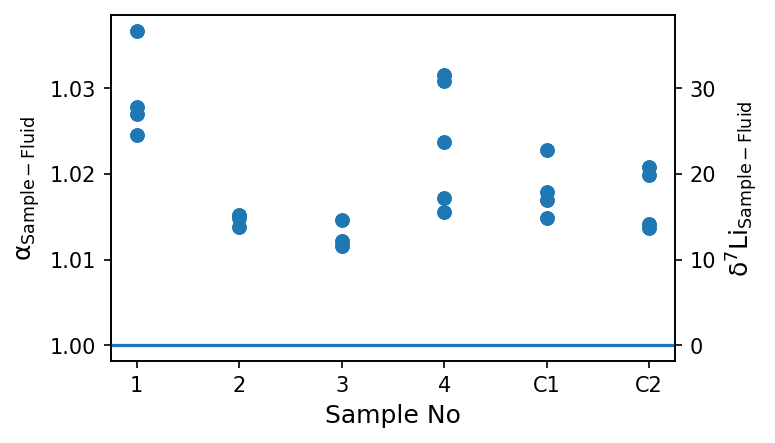

In [208]:
plt.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'alpha_Sample-Solution']), err(solids.loc[:, 'alpha_Sample-Solution']), marker='o', lw=0, elinewidth=1)
plt.axhline(1)
plt.ylabel('$\\alpha_{Sample-Fluid}$')
plt.xlabel('Sample No')

ax2 = plt.gca().twinx()
ax2.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'delta_Sample-Solution']), err(solids.loc[:, 'delta_Sample-Solution']), marker='o', lw=0, elinewidth=1)
ax2.axhline(0)
ax2.set_ylabel('$\\delta^7Li_{Sample-Fluid}$')